## SR

Relevant chats:

* https://claude.ai/share/64c68f34-8d47-4753-839a-7a24da388c85
*
* https://chatgpt.com/share/68c86cf9-29f4-800b-a073-43a69e79b17f
* https://chatgpt.com/share/68c7061b-5bdc-800b-9821-48fd1625ed65
* https://chatgpt.com/share/68c6111a-55d0-800b-b1b3-14e3cf3ff731

In [1]:
import IPython.display as ipd
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from PIL import Image

from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
device='cuda'

In [2]:
from elucidated_diffusion.image_helpers import sr_to_pil
from elucidated_diffusion.image_helpers import pil_to_data_url
from elucidated_diffusion.image_helpers import html_for_images
from elucidated_diffusion.checkpoint_helper import load_checkpoint, save_checkpoint
#from elucidated_diffusion.models.chatgpt_sr_unet import UNetSR3
from elucidated_diffusion.models.claude_sr_ViT import HybridViTUNetSR

from elucidated_diffusion.elucidated_diffusion import edm_ancestral_sampling_for_diffusion
from elucidated_diffusion.elucidated_diffusion import edm_ancestral_sampling_for_sr
from elucidated_diffusion.elucidated_diffusion import P_mean, P_std, sigma_data, edm_loss_weight
from elucidated_diffusion.dataset_helpers import get_datasets



In [3]:
# Sanity check the model's inputs and outputs are as expected
if sanity_check_model := True:
    model = HybridViTUNetSR()
    
    B = 2
    x_noisy = torch.randn(B, 3, 256, 256)
    lr_img = torch.randn(B, 3, 64, 64)
    t = torch.rand(B)
    
    with torch.no_grad():
        out = model(x_noisy, lr_img, t)
    
    print(f"Output shape: {out.shape}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Break down parameter count
    vit_params = sum(p.numel() for p in model.structure_vit.parameters())
    unet_params = sum(p.numel() for p in model.parameters()) - vit_params
    print(f"ViT parameters: {vit_params:,}")
    print(f"UNet + fusion parameters: {unet_params:,}")

Output shape: torch.Size([2, 3, 256, 256])
Total parameters: 27,386,307
ViT parameters: 11,109,632
UNet + fusion parameters: 16,276,675


## Ancestral Sampling.

In [4]:
if sanity_check_model := False:
    with torch.no_grad():
        edm_ancestral_sampling_for_sr(model,lrimg,batch_size=4,img_shape=(3,256,256))

In [5]:
# Modified from my diffusion model in a cell above.

from torch.amp.grad_scaler import GradScaler
scaler = GradScaler(device="cuda")
#from torch.cuda.amp import autocast
from torch.amp.autocast_mode import autocast


def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch
        hr_256, lr_64 = x
        # Move to device
        hr_256 = hr_256.to(device)          # [B, 3, 256, 256]
        lr_64 = lr_64.to(device)            # [B, 3, 64, 64]

        x = hr_256
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])


        # Upsample LR to HR resolution
        lr_up = F.interpolate(lr_64, size=hr_256.shape[-2:], mode='bilinear', align_corners=False)
        # Expected shape: [B, 3, 256, 256]

        ## Sample timestep t for each item in batch
        #b = hr_256.shape[0]
        
        # Concatenate noisy HR + upsampled LR for conditioning
        ###x_input = torch.cat([y_noisy, lr_up], dim=1)  # [B, 6, 256, 256]

        # --- Optional sanity assertions ---
        ###assert x_input.shape[1] == 6, f"Expected 6 channels, got {x_input.shape[1]}"
        ###assert hr_256.shape == noise.shape, "HR and noise shapes must match"


        # this_models_input = torch.cat([c_in * y_noisy, lr_up], dim=1).cuda()
        # From ChatGPT code review
        # this_models_input = torch.cat([c_in * y_noisy, c_in * lr_up], dim=1).cuda()
        # TODO: I'm not sure I trust that -- it looked pretty good before this change.
        # but then in a second chatgpt code review it asked me to reverse it again
        # https://chatgpt.com/share/68c7061b-5bdc-800b-9821-48fd1625ed65
        # Double-check this after it runs a long time
        ###this_models_input = torch.cat([c_in * y_noisy, lr_up], dim=1)
        
        with autocast(device_type="cuda"):
            #F_x = model_edm(this_models_input, c_noise_input)

            F_x = model_edm(c_in * y_noisy, lr_64, c_noise_input)  # No upsampling needed!


            # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
            D_x = c_skip * y_noisy + c_out * F_x
            # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
            #weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
            # 
            weight = edm_loss_weight(sigma.flatten(), sigma_data)[:, None, None, None]

            # Loss: weighted MSE between preconditioning output and clean image
            loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model_edm.parameters(), max_norm=1.0)
        scaler.step(optimizer_edm)
        scaler.update()
    
        return loss.item()


In [6]:
if sanity_check_model := False:

    model = HybridViTUNetSR().to(device)
    experiment_name = 'fantasy'
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

    lrds,paired_dataset = get_datasets('fantasy')
    
    train_loader = DataLoader(paired_dataset, batch_size=2, shuffle=False)
    batch = next(iter(train_loader))
    ipd.display(sr_to_pil(batch[0][0]))
    ipd.display(sr_to_pil(batch[1][0]))
    for i in range(100):
        loss = train_a_batch(model, optimizer, batch)
        print(loss)
    
    del(model)
    del(optimizer)
    import gc
    gc.collect()
# Sanity check the model's inputs and outputs are as expected


In [7]:
import time
from datetime import datetime
from tqdm import tqdm
import os
import mlflow
import mlflow.pytorch

from elucidated_diffusion.ema_helper import EMAHelper

def train_some_sr(model_edm, optimizer_edm, paired_dataset, resume_from=None, experiment_name=None):
    #mlflow.set_experiment("SR_ViT_Training")
    #mlflow.start_run(run_name=experiment_name)
    #mlflow_step_count = 0

    train_loader = DataLoader(paired_dataset, batch_size=2, shuffle=True)
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    if resume_from:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=resume_from)
    ema = EMAHelper(model_edm)    
    t0 = time.time()
    display_interval = 60
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    cls_name = model.__class__.__name__
    image_path = f"outputs/{cls_name}_{experiment_name}_{timestamp}.html"

    with open("/tmp/training_running.txt","w"):
        pass
    for epoch in range(9999999):
        if not os.path.exists("/tmp/training_running.txt"):
            break
        pbar = tqdm(train_loader)
        for x in pbar:
            if not os.path.exists("/tmp/training_running.txt"):
                break
            hr,lr = x
            #if not os.path.exists("/tmp/training_running.txt"):
            #    break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            ema.update(model_edm)


            #mlflow_step_count += 1
            #if mlflow_step_count % 10 == 0:  # Log every 10 steps
            #    print("might have logged to mlflow")
            #    mlflow.log_metric("loss", loss, step=mlflow_step_count)

            if experiment_name and (time.time() > next_checkpoint_time):
                path = save_checkpoint(model_edm, optimizer_edm, 85, 0.11, tag="_SR_"+experiment_name + "_raw_sr_tmp")
                path = save_checkpoint(ema.get_model(), optimizer_edm, 85, 0.11, tag="_SR_"+experiment_name + "_ema_sr_tmp")
                next_checkpoint_time = time.time() + checkpoint_interval
            if time.time() > next_display_time:
                with torch.no_grad():
                    next_display_time = next_display_time + 30
                    emamodel = ema.get_model()
                    out = edm_ancestral_sampling_for_sr(emamodel, lr[0:2].cuda(), num_steps=18,batch_size=2,img_shape=(3,256,256))
                    out2 = edm_ancestral_sampling_for_sr(emamodel, lr[0:2].cuda(), num_steps=18,batch_size=2,img_shape=(3,256,256), headstart_sigma=3)
                    out3 = edm_ancestral_sampling_for_sr(emamodel, lr[0:2].cuda(), num_steps=18,batch_size=2,img_shape=(3,256,256), headstart_sigma=1)
                    hri,lri,sri,sri2,sri3 = [sr_to_pil(i) for i in [hr[0],lr[0],out[0],out2[0],out3[0]]]
                    dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
                    title = f"SR training at {dt} loss {loss}"
                    h = html_for_images([hri,lri,lri.resize((256,256)),sri,sri2,sri3], title=title)
                    with open(image_path,"a") as f:
                        f.write(h)
                    ipd.clear_output(wait=True)
                    ipd.display(ipd.HTML(h))

            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")
    #mlflow.end_run()
    #print("ended mlflow run")

    if experiment_name:
        path = save_checkpoint(model_edm, optimizer_edm, 85, 0.11, tag="_SR_"+experiment_name + "_raw_sr_tmp")
        path = save_checkpoint(ema.get_model(), optimizer_edm, 85, 0.11, tag="_SR_"+experiment_name + "_ema_sr_tmp")
        
    del model_edm,optimizer_edm
    return path if experiment_name else ema

In [8]:
model = HybridViTUNetSR().to(device)
experiment_name = 'fantasy'
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
lrds,paired_dataset = get_datasets('fantasy')
train_loader = DataLoader(paired_dataset, batch_size=2, shuffle=False)
#good_path = 'checkpoints/UNetSR3_2025-09-15_08-14-19__SR_fantasy_really_good.pth'
#good_path = 'checkpoints/UNetSR3_2025-09-15_19-38-09__SR_dragon_really_good.pth'
#good_path = 'checkpoints/UNetSR3_2025-09-15_08-14-19__SR_fantasy_really_good.pth'
#load_checkpoint(model, optimizer, good_path)
#ipd.display(sr_to_pil(next(iter(paired_dataset))[0]))

In [9]:
1/0

ZeroDivisionError: division by zero


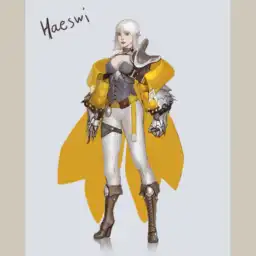
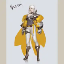
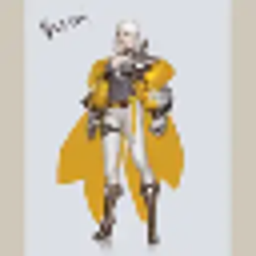
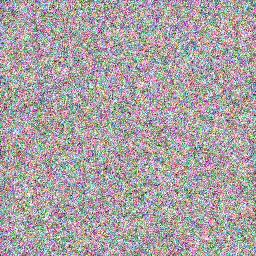
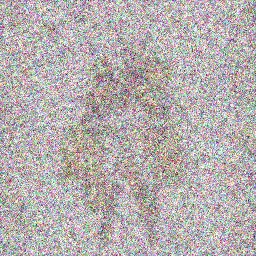
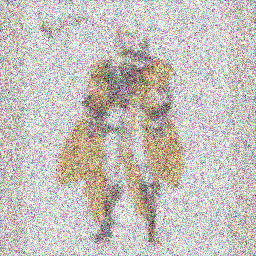

EDM Epoch 1 Loss: 1.1163:   3%|▎         | 183/6407 [00:43<24:50,  4.17it/s]  


KeyboardInterrupt: 

In [ ]:

train_some_sr(model, optimizer,paired_dataset)

In [ ]:
#save_checkpoint(model, optimizer, 3, 0.05, tag="_SR_ViT_"+experiment_name + "_raw_sr")


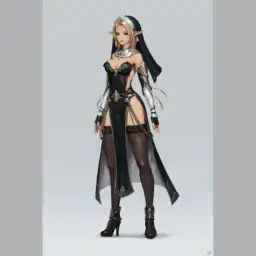
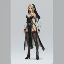
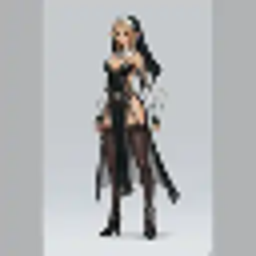
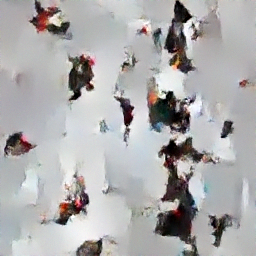
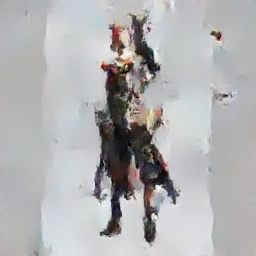
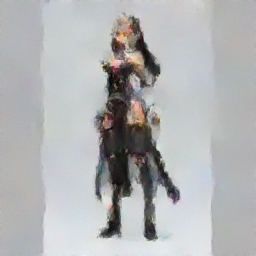

EDM Epoch 1 Loss: 0.0719:   5%|▍         | 315/6407 [01:12<16:31,  6.14it/s]  

In [ ]:

good_checkpoint = 'checkpoints/HybridViTUNetSR_2025-09-20_00-06-51__SR_ViT_fantasy_raw_sr.pth'
train_some_sr(model, optimizer,paired_dataset, resume_from=good_checkpoint)